Train samples: 32572
Val samples: 10858
Test samples: 10876
Found 32572 validated image filenames belonging to 38 classes.
Found 10858 validated image filenames belonging to 38 classes.
Found 10876 validated image filenames belonging to 38 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 534s 400ms/step - accuracy: 0.7245 - loss: 1.1339 - val_accuracy: 0.9851 - val_loss: 0.0502
Epoch 2/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 294s 288ms/step - accuracy: 0.9789 - loss: 0.0779 - val_accuracy: 0.9889 - val_loss: 0.0360
Epoch 3/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 293s 287ms/step - accuracy: 0.9892 - loss: 0.0367 - val_accuracy: 0.9916 - val_loss: 0.0269
Epoch 4/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 293s 287ms/step - accuracy: 0.9931 - loss: 0.0246 - val_accuracy: 0.9925 - val_loss: 0.0220
Epoch 5/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 292s 287ms/step - accuracy: 0.9953 - loss: 0.0182 - val_accuracy: 0.9904 - val_loss: 0.0376
Epoch 6/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 293s 287ms/step - accuracy: 0.9941 - loss: 0.0180 - val_accuracy: 0.9903 - val_loss: 0.0346
Epoch 7/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 294s 288ms/step - accuracy: 0.9963 - loss: 0.0121 - val_accuracy: 0.9898 - val_loss: 0.0386
Epoch 8/30
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 293s 288ms/step - accuracy: 0.9

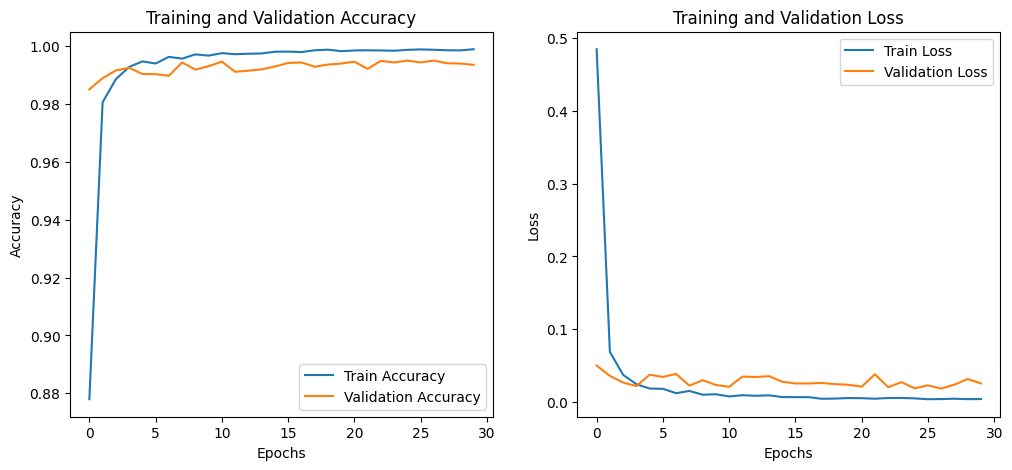

340/340 ━━━━━━━━━━━━━━━━━━━━ 78s 229ms/step - accuracy: 0.9938 - loss: 0.0297
Test Accuracy: 0.9938
340/340 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step


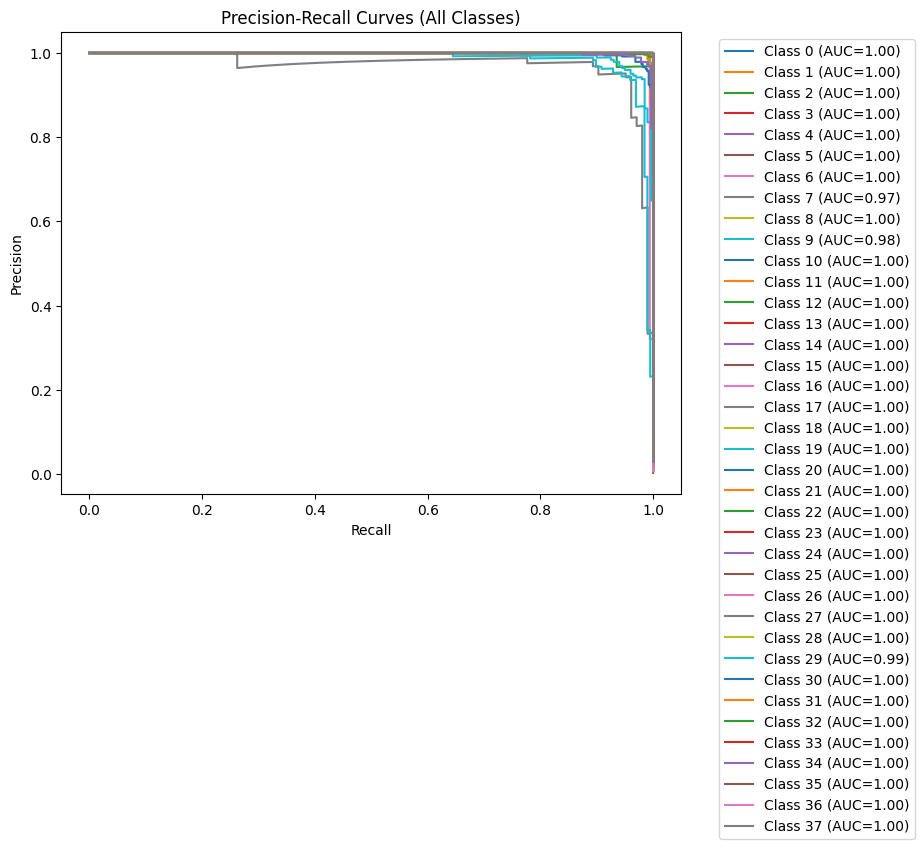

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       126
           1       1.00      1.00      1.00       125
           2       1.00      1.00      1.00        55
           3       0.99      1.00      1.00       329
           4       1.00      1.00      1.00       301
           5       1.00      1.00      1.00       211
           6       1.00      0.99      1.00       171
           7       0.87      0.96      0.91       103
           8       1.00      0.98      0.99       239
           9       0.96      0.92      0.94       197
          10       0.99      1.00      1.00       233
          11       1.00      1.00      1.00       236
          12       1.00      1.00      1.00       277
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00        85
          15       1.00      1.00      1.00      1102
          16       1.00      1.00      1.00       460
          17       1.00    

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, precision_recall_curve, auc


DATASET_PATH = "/kaggle/input/rgb-leaf-disease/segmented"  
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 38 


#  shuffle & split 60/20/20.
class_names = sorted(os.listdir(DATASET_PATH))
all_train_records = []
all_val_records = []
all_test_records = []

for class_name in class_names:
    class_dir = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_dir):
        continue  # Skip any non-folder files
    
    # Get all images in this class folder
    all_images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Shuffle them
    np.random.shuffle(all_images)
    
    # Compute split indices
    total_count = len(all_images)
    train_end = int(0.6 * total_count)  # 60%
    val_end = int(0.8 * total_count)    # 80% (so next 20% is val)
    # last 20% is test
    
    train_paths = all_images[:train_end]
    val_paths   = all_images[train_end:val_end]
    test_paths  = all_images[val_end:]
    
    # Add to lists (DataFrame rows): we store [filepath, class_name]
    for p in train_paths:
        all_train_records.append((p, class_name))
    for p in val_paths:
        all_val_records.append((p, class_name))
    for p in test_paths:
        all_test_records.append((p, class_name))

# Create DataFrames: columns must be ["filename", "class"] for flow_from_dataframe
train_df = pd.DataFrame(all_train_records, columns=["filename", "class"])
val_df   = pd.DataFrame(all_val_records,   columns=["filename", "class"])
test_df  = pd.DataFrame(all_test_records,  columns=["filename", "class"])

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))
print("Test samples:", len(test_df))

datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


base_model = EfficientNetB3(weights="imagenet", include_top=False, 
                            input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output_layer = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,  # adjust as needed
    verbose=1
)


model.save("/kaggle/working/efficientnet_model.h5")


def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy Plot
    ax[0].plot(history.history["accuracy"], label="Train Accuracy")
    ax[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    ax[0].set_title("Training and Validation Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # Loss Plot
    ax[1].plot(history.history["loss"], label="Train Loss")
    ax[1].plot(history.history["val_loss"], label="Validation Loss")
    ax[1].set_title("Training and Validation Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.show()

plot_history(history)


test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")



# True labels and predicted probabilities
y_true = test_gen.classes  # numeric labels
y_pred_probs = model.predict(test_gen)

# Convert numeric labels to one-hot
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=NUM_CLASSES)

# Plot PR curve for each class in one figure
plt.figure(figsize=(8, 6))

for i in range(NUM_CLASSES):
    # precision_recall_curve(true_binary, predicted_probs_for_class)
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"Class {i} (AUC={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (All Classes)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


y_pred_labels = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_true, y_pred_labels))


Final Accuracy
99.3%